In [17]:
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from khipu.extended import peaklist_to_khipu_list, export_empCpd_khipu_list
from mining import * 

In [2]:
# Input data 

orbi_datasets = [x.rstrip() for x in open('selected_45_orbi_datasets.txt').readlines()]
pos_orbi_datasets = [x for x in orbi_datasets if 'pos' in x]
neg_orbi_datasets = [x for x in orbi_datasets if 'neg' in x]

dict_tablefiles = {}
for line in open('list_input_files.tsv').readlines():
    a = line.rstrip().split('\t')
    dict_tablefiles[a[0]] = a[1]

dict_rtwindow = {}
for line in open('elution_parameters_45studies.tsv').readlines()[1:]:
    a = line.rstrip().split('\t')
    dict_rtwindow[a[0]] = float(a[5])

**Next block is from last step without modification**

In [3]:
def get_features_in_rtwindow(list_features, rt_ref, rt_stdev):
    '''
    returns features in list_features that are within rt_stdev
    '''
    return [f for f in list_features if abs(f['rtime']-rt_ref) <= rt_stdev]   

def get_khipus_in_rtwindow(list_khipus, rt_ref, rt_stdev):
    '''
    returns features in list_features that are within rt_stdev
    '''
    return [f for f in list_khipus if abs(f['MS1_pseudo_Spectra'][0]['rtime']-rt_ref) <= rt_stdev]  

def mz_in_list(mz, mlist, max_diff=0.0005, ppm=5):
    '''
    Only considering positive mz values.
    mz can be zero, which is False match.
    '''
    r = False
    if mz > max_diff:
        deltas = sorted([abs(x-mz) for x in mlist])
        if deltas[0] <= max_diff or deltas[0]/mz < ppm*1e-6:
            r = True
    return r 
    
def explain_a_dataset(list_khipus, remaining_features, isf_candidate_fragments, rt_stdev=0.613):
    '''
    list_khipus : sorted by descending mass.
    
    Khipus and other features explained by isf_candidate_fragments.
    Record explained khipus, features, [(delta_mz, id, delta_rt)]
    '''
    explained_khipu_ids, explained_feature_ids = [], []
    delta_values_used = []
    
    for ii in range(len(list_khipus)-1):
        _m0 = get_M0(list_khipus[ii]['MS1_pseudo_Spectra'])
        rt_ref = _m0['rtime']
        base_mz = _m0['mz']
        khipus_in_rtwindow = get_khipus_in_rtwindow(
            list_khipus[ii+1:], 
            rt_ref, 
            rt_stdev)
        for k in khipus_in_rtwindow:
            _d = list_khipus[ii]['neutral_formula_mass']-k['neutral_formula_mass']
            if mz_in_list(_d, isf_candidate_fragments):  # Only considering positive mz values.
                explained_khipu_ids.append(k['interim_id'])
                delta_values_used.append(
                    (_d, k['interim_id'], rt_ref-get_M0(k['MS1_pseudo_Spectra'])['rtime']))
            
        features_in_rtwindow = get_features_in_rtwindow(
            remaining_features, 
            rt_ref, 
            rt_stdev)
        for f in features_in_rtwindow:
            _d = base_mz - f['mz']
            if mz_in_list(
                _d, isf_candidate_fragments
            ):
                explained_feature_ids.append(f['id'])
                delta_values_used.append(
                    (_d, f['id'], rt_ref-f['rtime']))
                
    return explained_khipu_ids, explained_feature_ids, delta_values_used

In [4]:
# pos ionization
isotope_search_patterns = [ (1.003355, '13C/12C', (0, 0.8)),
                            (2.00671, '13C/12C*2', (0, 0.8)),
                            (3.010065, '13C/12C*3', (0, 0.8)),
                            (3.9948, '44Ca/40Ca', (0, 0.1)), # 2%
                            (1.9970, '37Cl/35Cl', (0.1, 0.8)), # 24.24%
                            ]

adduct_search_patterns_pos = [  # initial patterns are relative to M+H+
                            (21.98194, 'Na/H'),
                            (41.026549, 'ACN'),     # Acetonitrile
                            (67.987424, 'NaCOOH'),
                            (37.955882, 'K/H'),
                            ]
adduct_search_patterns_neg = [  
                            (21.98194, 'Na/H'), (67.987424, 'NaCOOH'),
                            (82.0030, 'C2HF3'),
                            (1.99566, 'F <-> OH'), 
                            (41.026549, 'ACN'),
                            (37.955882, 'K/H'),
                            ]
extended_adducts = [  # excluding neutral loss here; include as a step after khipu
                            (1.0078, 'H'),
                            (17.02655, 'NH3'),
                            (18.0106, 'H2O'),      # easy to confuse with bio reactions
                            (18.033823, 'NH4'),
                            (27.01089904, 'HCN'),
                            (27.99492, 'CO'),
                            (32.026215, 'MeOH'),
                            (-35.037114, '-NH3-H2O'), # not incuded in candidates below
                            (35.9767, 'HCl'),
                            (37.94694, 'Ca/H2'),
                            (43.96389, 'Na2/H2'),
                            (46.00548, 'CO2H2'),
                            (67.987424, 'NaCOOH'),
                            (83.961361, 'KCOOH'),
                            (97.96737927, 'H2SO4'),
                            (97.97689507, 'H3PO4'),
]

candidate_fragments = '''14.0155	792	14.0155	['14.01565', "± CH2, alkane chains, waxes, fatty acids, methylation; or '-[C3H6ON] <-> -[C2H4ON], acrylamide versus iodoacetamide in cysteine alkylation (gels)", "{'C': 1, 'H': 2}"]
18.0104	780	18.0104	['-18.010565', 'H2O', "{'H': -2, 'O': -1}"]
2.0156	634	2.0156	['2.01565', '± 2H, opening or forming of double bond', "{'H': 2}"]
28.0312	550	28.0312	['28.0313', '± C2H4, natural alkane chains such as fatty acids', "{'C': 2, 'H': 4}"]
15.9948	420	15.9948	['15.99492', '± O, e.g. oxidation/reduction', "{'O': 1}"]
17.0264	404	17.0264	['-17.026549', 'NH3', "{'N': -1, 'H': -3}"]
26.0155	392	26.0155	[' C2H2']
27.9948	385	27.9948	['27.99492', '± CO', "{'C': 1, 'O': 1}"]
32.026	311	32.0261	['32.026215', 'MeOH', "{'C': 1, 'H': 4, 'O': 1}"]
42.0104	301	42.0104	['42.01057', '± COCH2', "{'C': 2, 'O': 1, 'H': 2}"]
67.9872	295	67.9873	['67.987424', 'NaCOOH', "{'C': 1, 'O': 2, 'Na': 1, 'H': 1}"]
13.9791	287	13.9791	['13.97927', 'O <-> 2H, e.g. Oxidation follwed by H2O elimination', "{'H': -2, 'O': 1}"]
42.0468	278	42.0468	['42.04695', '± C3H6, propylation', "{'C': 3, 'H': 6}"]
46.0053	277	46.0053	['-46.005479', 'H2O+CO', "{'C': -1, 'H': -2, 'O': -2}"]
'''
candidate_fragments = [
    (float(x.split()[0]), x) for x in candidate_fragments.splitlines()
]
isf_candidate_fragments = [x[0] for x in candidate_fragments]

In [5]:
def assign_intensity_quartile(list_features):
    '''
    example feature : {'id_number': 'F101',
                'id': 'F101',
                'mz': 113.8853,
                'rtime': 261.81,
                'apex': 261.81,
                'left_base': 261.02,
                'right_base': 263.65,
                'parent_masstrack_id': '1034',
                'peak_area': '433995',
                'cSelectivity': '0.75',
                'goodness_fitting': '0.98',
                'snr': '3',
                'detection_counts': '39',
                'representative_intensity': '433995'}
    returns dict {fid: quartile, ...}
    '''
    for f in list_features:
        f['peak_area'] = float(f['peak_area'])
    d = {}
    intensities = np.array([f['peak_area'] for f in list_features])
    x1, x2, x3 = np.quantile(intensities, 0.75
                        ), np.quantile(intensities, 0.5
                         ), np.quantile(intensities, 0.25)
    
    for f in list_features:
        if f['peak_area'] > x1:
            d[f['id']] = 1  # 1st quartile
        elif x1 >= f['peak_area'] > x2:
            d[f['id']] = 2
        elif x2 >= f['peak_area'] > x3:
            d[f['id']] = 3
        else:
            d[f['id']] = 4
    return d

In [7]:
# Detailed explanation of features by khipus and frequent deltas
# **Include feature intensity ranks**
# ~ 50 minutes

tally_pos = []
for study in pos_orbi_datasets:
    ion_mode = 'pos'
    _n, list_features = read_features_from_asari_table(
        open(dict_tablefiles[study]).read()
        )
    for f in list_features:
        f['representative_intensity'] = f['peak_area']
    list_khipus, all_assigned_fids = peaklist_to_khipu_list(
                            list_features, 
                            isotope_search_patterns=isotope_search_patterns, 
                            adduct_search_patterns=adduct_search_patterns_pos,
                            extended_adducts=extended_adducts, 
                            mz_tolerance_ppm=5,
                            rt_tolerance=dict_rtwindow[study],
                            mode=ion_mode,
                            charges=[1, 2, 3],
                            )
    # convert khipu instances to dicts
    list_khipus = sorted(export_empCpd_khipu_list(list_khipus), 
                         key=lambda x: x['neutral_formula_mass'], reverse=True)
    remaining_features = [f for f in list_features if f['id'] not in all_assigned_fids]
    
    # by isf_candidate_fragments
    explained_khipu_ids, explained_feature_ids, delta_values_used = explain_a_dataset(
        list_khipus, remaining_features, isf_candidate_fragments, 
        rt_stdev=dict_rtwindow[study]
        )

    dict_intensity_quartile = assign_intensity_quartile(list_features)
    preannotated_feature_ids = set(list(all_assigned_fids) + explained_feature_ids)
    quartile_matches = [dict_intensity_quartile[x] for x in preannotated_feature_ids]

    tally_pos.append(
        {
            'study': study,
            'num_khipus': len(list_khipus),
            'num_features':  len(list_features),
            'mzdelta_explained_khipus': len(set(explained_khipu_ids)), 
            'mzdelta_explained_features': len(set(explained_feature_ids)),
            'quartile_matches': quartile_matches,
        }
    )

table header looks like: 
   ['id_number', 'mz', 'rtime', 'rtime_left_base', 'rtime_right_base', 'parent_masstrack_id', 'peak_area', 'cSelectivity', 'goodness_fitting', 'snr', 'detection_counts', '1120a_Marios_PD1_Inhib2_HP-PREFA58', '1040_Marios_PD1_Inhib2_HP-EA717425-8', '1040a_Marios_PD1_Inhib2_HP-PREFA54', '1040b_Marios_PD1_Inhib2_HP-PREFB54', '1041_Marios_PD1_Inhib2_HP-E9133655-7', '1042_Marios_PD1_Inhib2_HP-L1376088-6', '1043_Marios_PD1_Inhib2_HP-L1305560-7', '1044_Marios_PD1_Inhib2_HP-L1370589-6', '1045_Marios_PD1_Inhib2_HP-E9123619-6']
Read 57875 feature lines


Multiple charges considered: [1, 2, 3]


Khipu search grid: 
               M+H+       Na/H        K/H        ACN     NaCOOH
M0         1.007276  22.989216  38.963158  42.033825  68.994700
13C/12C    2.010631  23.992571  39.966513  43.037180  69.998055
37Cl/35Cl  3.004276  24.986216  40.960158  44.030825  70.991700
13C/12C*2  3.013986  24.995926  40.969868  44.040535  71.001410
13C/12C*3  4.017341  25.999281  41.973223 

In [9]:
test0 = tally_pos[0]['quartile_matches']
tally_pos[0]['num_features'], [
    len([x for x in test0 if x ==1]), len([x for x in test0 if x ==2]), 
    len([x for x in test0 if x ==3]), len([x for x in test0 if x ==4]),
]

(57875, [9622, 4926, 2041, 967])

In [33]:
# Get numbers of features explained by pre-annotation (= len(quartile_matches)), 
# and unique empCpds (= num_khipus - mzdelta_explained_khipus)
# 

preannotated_features = [len(x['quartile_matches']) for x in tally_pos]
unique_empCpds = [x['num_khipus']-x['mzdelta_explained_khipus'] for x in tally_pos]

quartile_percs = [[], [], [], []]
for x in tally_pos:
    list_q = x['quartile_matches']
    quartile_size = x['num_features']/4
    for ii in range(4):
        quartile_percs[ii].append(100 * len([y for y in list_q if y==ii+1]) / quartile_size)
    
median_perc = [np.median(quartile_percs[ii]) for ii in range(4)]
median_perc

[66.52155809744212, 34.31484356215387, 18.85608071679517, 11.428083623905836]

17499.5 5675.5


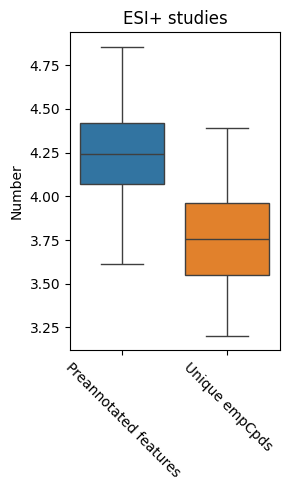

In [ ]:
# Fig 3a. preannotated_features unique_empCpds
_d = {
    'Preannotated features': np.log10(preannotated_features),
    'Unique empCpds': np.log10(unique_empCpds),
}

print(np.median(preannotated_features), np.median(unique_empCpds))

fig, ax = plt.subplots(1, 1, figsize=(3, 5))
sns.boxplot(data=_d)
ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("log10(Number)")
ax.set_title("ESI+ studies")
plt.tight_layout()
plt.savefig('Fig3a_preannotation_pos.pdf')

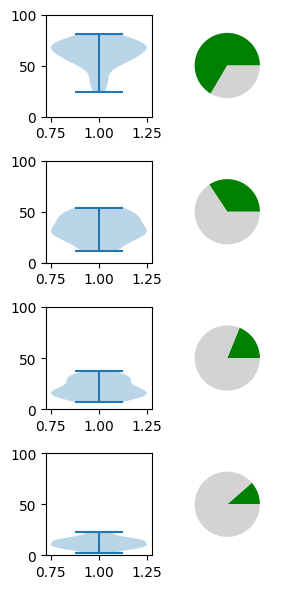

In [35]:
# Fig. 3b. distribution of perc; pie chart for median pec
# plot barplot for 
piedata = [(x, 100-x) for x in median_perc]

fig, axs = plt.subplots(4, 2, figsize=(3, 6))
for ii in range(4):
    axs[ii, 0].violinplot(quartile_percs[ii]) #, color='lg')
    axs[ii, 0].set_ylim(0, 100)
    axs[ii, 1].pie(piedata[ii], colors=['green', 'lightgray'], radius=.8) 
    
plt.tight_layout()
plt.savefig("Fig3b_preannotation_pos_piecharts.pdf")

## Do neg ion studies

In [10]:
neg_candidate_fragments = '''67.9874	762	67.9873	['67.987424', 'NaCOOH', "{'C': 1, 'O': 2, 'Na': 1, 'H': 1}"]
14.0156	614	14.0155	['14.01565', "± CH2, alkane chains, waxes, fatty acids, methylation; or '-[C3H6ON] <-> -[C2H4ON], acrylamide versus iodoacetamide in cysteine alkylation (gels)", "{'C': 1, 'H': 2}"]
2.0156	510	2.0156	['2.01565', '± 2H, opening or forming of double bond', "{'H': 2}"]
82.0029	401	82.0029	['82.0030 C2HF3']
15.9948	371	15.9948	['15.99492', '± O, e.g. oxidation/reduction', "{'O': 1}"]
43.9898	356	43.9897	['43.98983', '± CO2', "{'C': 1, 'O': 2}"]
18.0105	332	18.0104	['-18.010565', 'H2O', "{'H': -2, 'O': -1}"]
26.0156	313	26.0155	[' C2H2']
46.0054	308	46.0053	['-46.005479', 'H2O+CO', "{'C': -1, 'H': -2, 'O': -2}"]
28.0312	299	28.0312	['28.0313', '± C2H4, natural alkane chains such as fatty acids', "{'C': 2, 'H': 4}"]
27.9948	267	27.9948	['27.99492', '± CO', "{'C': 1, 'O': 1}"]
1.9957	255	1.9957	['1.99566', 'F <-> OH, halogen exchange with hydroxy group (typically -F + OH)', "{'F': 1, 'O': -1, 'H': -1}"]
42.0105	229	42.0104	['42.01057', '± COCH2', "{'C': 2, 'O': 1, 'H': 2}"]
'''
neg_candidate_fragments = [
    (float(x.split()[0]), x) for x in neg_candidate_fragments.splitlines()
]

isf_candidate_fragments_neg = [x[0] for x in neg_candidate_fragments]

In [11]:
# Detailed explanation of features by khipus and frequent deltas
# **Include feature intensity ranks**
# ~ 70 minutes

tally_neg = []
for study in neg_orbi_datasets:
    ion_mode = 'neg'
    _n, list_features = read_features_from_asari_table(
        open(dict_tablefiles[study]).read()
        )
    for f in list_features:
        f['representative_intensity'] = f['peak_area']
    list_khipus, all_assigned_fids = peaklist_to_khipu_list(
                            list_features, 
                            isotope_search_patterns=isotope_search_patterns, 
                            adduct_search_patterns=adduct_search_patterns_neg,
                            extended_adducts=extended_adducts, 
                            mz_tolerance_ppm=5,
                            rt_tolerance=dict_rtwindow[study],
                            mode=ion_mode,
                            charges=[1, 2, 3],
                            )
    # convert khipu instances to dicts
    list_khipus = sorted(export_empCpd_khipu_list(list_khipus), 
                         key=lambda x: x['neutral_formula_mass'], reverse=True)
    remaining_features = [f for f in list_features if f['id'] not in all_assigned_fids]
    
    # by isf_candidate_fragments
    explained_khipu_ids, explained_feature_ids, delta_values_used = explain_a_dataset(
        list_khipus, remaining_features, isf_candidate_fragments_neg, 
        rt_stdev=dict_rtwindow[study]
        )

    dict_intensity_quartile = assign_intensity_quartile(list_features)
    preannotated_feature_ids = set(list(all_assigned_fids) + explained_feature_ids)
    quartile_matches = [dict_intensity_quartile[x] for x in preannotated_feature_ids]

    tally_neg.append(
        {
            'study': study,
            'num_khipus': len(list_khipus),
            'num_features':  len(list_features),
            'mzdelta_explained_khipus': len(set(explained_khipu_ids)), 
            'mzdelta_explained_features': len(set(explained_feature_ids)),
            'quartile_matches': quartile_matches,
        }
    )

table header looks like: 
   ['id_number', 'mz', 'rtime', 'rtime_left_base', 'rtime_right_base', 'parent_masstrack_id', 'peak_area', 'cSelectivity', 'goodness_fitting', 'snr', 'detection_counts', 'QXA13POL20180807_MSSM0118ML_HUMAN_SERUM4_35', 'QXA13POL20180807_MSSM0118ML_HUMAN_SERUM1_03', 'QXA13POL20180807_MSSM0118ML_HUMAN_SERUM1_04', 'QXA13POL20180807_MSSM0118ML_HUMAN_SERUM1_05', 'QXA13POL20180807_MSSM0118ML_HUMAN_SERUM1_06', 'QXA13POL20180807_MSSM0118ML_HUMAN_SERUM1_07', 'QXA13POL20180807_MSSM0118ML_HUMAN_SERUM1_08', 'QXA13POL20180807_MSSM0118ML_HUMAN_SERUM1_09', 'QXA13POL20180807_MSSM0118ML_HUMAN_SERUM1_10']
Read 35496 feature lines


Multiple charges considered: [1, 2, 3]


Khipu search grid: 
               M-H-  F <-> OH       Na/H        K/H        ACN     NaCOOH  \
M0        -1.007276  0.988384  20.974664  36.948606  40.019273  66.980148   
13C/12C   -0.003921  1.991739  21.978019  37.951961  41.022628  67.983503   
37Cl/35Cl  0.989724  2.985384  22.971664  38.945606  42.016273

In [36]:
# Get numbers of features explained by pre-annotation (= len(quartile_matches)), 
# and unique empCpds (= num_khipus - mzdelta_explained_khipus)
# 

preannotated_features = [len(x['quartile_matches']) for x in tally_neg]
unique_empCpds = [x['num_khipus']-x['mzdelta_explained_khipus'] for x in tally_neg]

quartile_percs = [[], [], [], []]
for x in tally_neg:
    list_q = x['quartile_matches']
    quartile_size = x['num_features']/4
    for ii in range(4):
        quartile_percs[ii].append(100 * len([y for y in list_q if y==ii+1]) / quartile_size)
    
median_perc = [np.median(quartile_percs[ii]) for ii in range(4)]
median_perc

[62.30656562440298, 38.174807197943444, 22.115027829313544, 14.461130009126359]

17974.0 6224.0


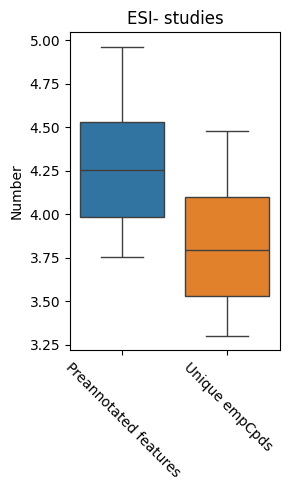

In [ ]:
# Fig 3c. preannotated_features unique_empCpds
_d = {
    'Preannotated features': np.log10(preannotated_features),
    'Unique empCpds': np.log10(unique_empCpds),
}

print(np.median(preannotated_features), np.median(unique_empCpds))

fig, ax = plt.subplots(1, 1, figsize=(3, 5))
sns.boxplot(data=_d)
ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("og10(Number)")
ax.set_title("ESI- studies")
plt.tight_layout()
plt.savefig('Fig3c_preannotation_neg.pdf')

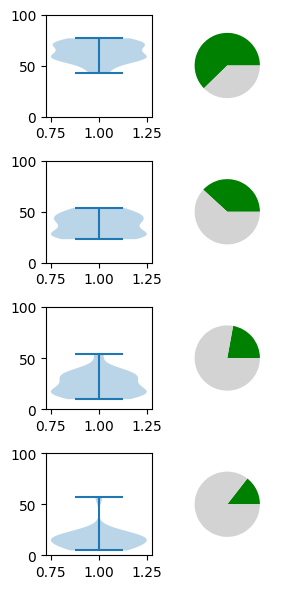

In [38]:
# Fig. 3d. distribution of perc; pie chart for median pec
# plot barplot for 
piedata = [(x, 100-x) for x in median_perc]

fig, axs = plt.subplots(4, 2, figsize=(3, 6))
for ii in range(4):
    axs[ii, 0].violinplot(quartile_percs[ii]) #, color='lg')
    axs[ii, 0].set_ylim(0, 100)
    axs[ii, 1].pie(piedata[ii], colors=['green', 'lightgray'], radius=.8) 
    
plt.tight_layout()
plt.savefig("Fig3d_preannotation_neg_piecharts.pdf")

# Conclusion

This notebook plots Figure 3. 

Numbers of pre-annotated features by extended khipus in all studies.
a,b. Distribution of numbers of pre-annotated features, median value 17,499 and 17,974 for positive and negative ionization datasets, respectively. They correspond to 5,675 and 6,224 unique empirical compounds, respectively.

 c,d. Percentage distribution of pre-annotated features in each intensity quartile in each study, for positive and negative ionization datasets, respectively. The pie charts show median percentage in each quartile, respectively. 